In [1]:
from ultralytics import YOLO
import os
import torch
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.optim as optim
import plot
import distance_estimation
import utils
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
robot_height = 0.545 # m
torch.manual_seed(0)

In [3]:
ROOT = './csv_data/Spherical_Coordinate/'
path_dir = os.listdir(ROOT)
path_dir

['Corridor_2024-02-06-21-34-18.txt',
 'Corridor_2024-02-06-21-40-49.txt',
 'Level1_2024-02-20-16-34-57.txt',
 'Level1_2024-02-20-16-44-28.txt',
 'Level1_Enhanced_2024-03-12-14-30-14.txt',
 'Level1_Enhanced_2024-03-12-14-50-28.txt',
 'Level1_Straight_Line_2024-03-01-17-27-00.csv',
 'with_predictions']

In [4]:
# first_floor_day2 = pd.read_csv(ROOT + path_dir[6])
# first_floor_other_than_day2 = pd.read_csv(ROOT + path_dir[7])
corridor_set1_df = pd.read_csv(ROOT + path_dir[0], sep = ' ')
corridor_set2_df = pd.read_csv(ROOT + path_dir[1], sep = ' ')
first_floor_day1_set1_df = pd.read_csv(ROOT + path_dir[2], sep = ' ')
first_floor_day1_set2_df = pd.read_csv(ROOT + path_dir[3], sep = ' ')
first_floor_day2_set1_df = pd.read_csv(ROOT + path_dir[4], sep = ' ')
first_floor_day2_set2_df = pd.read_csv(ROOT + path_dir[5], sep = ' ')
first_floor_straight = pd.read_csv(ROOT + path_dir[6], sep = ',')
# set1 = pd.read_csv(ROOT + path_dir[8])
# set2 = pd.read_csv(ROOT + path_dir[9])

In [5]:
corridor_set1_df = utils.calc_uvwh(corridor_set1_df.dropna())
corridor_set2_df = utils.calc_uvwh(corridor_set2_df.dropna())
first_floor_day1_set1_df = utils.calc_uvwh(first_floor_day1_set1_df.dropna())
first_floor_day1_set2_df = utils.calc_uvwh(first_floor_day1_set2_df.dropna())
first_floor_day2_set1_df = utils.calc_uvwh(first_floor_day2_set1_df.dropna())
first_floor_day2_set2_df = utils.calc_uvwh(first_floor_day2_set2_df.dropna())
first_floor_straight = utils.calc_uvwh(first_floor_straight.dropna())


d:\Ulindu\turtlebot_detection\utils.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['u'][idx] = u
d:\Ulindu\turtlebot_detection\utils.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['v'][idx] = v
d:\Ulindu\turtlebot_detection\utils.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['w'][idx] = w
d:\Ulindu\turtlebot_detection\utils.py:449: SettingWithCopyWarning: 
A value is trying to be set on a c

In [6]:
corridor_set1_df[['u','v','w','h']]=corridor_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
corridor_set2_df[['u','v','w','h']]=corridor_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day1_set1_df[['u','v','w','h']]=first_floor_day1_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day1_set2_df[['u','v','w','h']]=first_floor_day1_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day2_set1_df[['u','v','w','h']]=first_floor_day2_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day2_set2_df[['u','v','w','h']]=first_floor_day2_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_straight[['u','v','w','h']]=first_floor_straight[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)

In [7]:
first_floor_day1_set1_df

Unnamed: 0                 filename     gt_x      gt_y  gt_heading  \
0             0  1708418097.194988_F.jpg  1.08000  0.160000    0.034907   
1             1  1708418098.197396_F.jpg  1.08000  0.160000    0.034907   
2             2  1708418099.236570_F.jpg  1.08000  0.160000    0.034907   
3             3  1708418100.374095_F.jpg  1.15692  0.173431    0.032638   
4             4  1708418101.192885_F.jpg  1.29152  0.189010    0.035605   
..          ...                      ...      ...       ...         ...   
366         366  1708418579.225012_F.jpg  1.26218  0.307585    0.189194   
367         367  1708418580.351988_F.jpg  1.26218  0.307585    0.189194   
368         368  1708418581.178134_F.jpg  1.26218  0.307585    0.189194   
369         369  1708418582.173971_F.jpg  1.26218  0.307585    0.189194   
370         370  1708418583.200038_F.jpg  1.26218  0.307585    0.189194   

         x1      y1      x2      y2        X1  ...        Z3        X4  \
0    1354.5  1583.6  1602.4  1927.2 -0.108961  ...  0.816571  0.178420   
1    1354.4  1583.5  1602.6  1927.1 -0.109083  ...  0.816625  0.178647   
2    1354.5  1583.8  1602.2  1926.9 -0.108958  ...  0.816767  0.178216   
3    1354.5  1583.6  1602.3  1926.9 -0.108961  ...  0.816767  0.178327   
4    1354.8  1583.4  1601.7  1927.5 -0.108599  ...  0.816408  0.177629   
..      ...     ...     ...     ...       ...  ...       ...       ...   
366  1309.0  1583.7  1545.9  1907.2 -0.163899  ...  0.822831  0.116182   
367  1309.5  1582.3  1545.9  1906.8 -0.163323  ...  0.823172  0.116197   
368  1309.4  1582.1  1544.9  1906.4 -0.163447  ...  0.823408  0.115082   
369  1309.3  1581.9  1544.6  1905.3 -0.163571  ...  0.824086  0.114782   
370  1309.3  1582.0  1544.7  1905.5 -0.163569  ...  0.823960  0.114888   

           Y4        Z4  abs_dist     angle         u         v         w  \
0    0.565247  0.805395  1.091788  1.717875  0.513351  0.609514  0.086076   
1    0.565141  0.805419  1.091788  1.717875  0.513368  0.609479  0.086181   
2    0.564975  0.805631  1.091788  1.717875  0.513316  0.609497  0.086007   
3    0.564969  0.805611  1.169847  1.719596  0.513333  0.609462  0.086042   
4    0.565571  0.805343  1.305277  1.716112  0.513281  0.609531  0.085729   
..        ...       ...       ...       ...       ...       ...       ...   
366  0.548763  0.827865  1.299118  1.809831  0.495642  0.606059  0.082257   
367  0.548376  0.828120  1.299118  1.809831  0.495729  0.605747  0.082083   
368  0.548025  0.828508  1.299118  1.809831  0.495538  0.605642  0.081771   
369  0.546969  0.829247  1.299118  1.809831  0.495469  0.605417  0.081701   
370  0.547159  0.829106  1.299118  1.809831  0.495486  0.605469  0.081736   

            h  
0    0.119306  
1    0.119306  
2    0.119132  
3    0.119201  
4    0.119479  
..        ...  
366  0.112326  
367  0.112674  
368  0.112604  
369  0.112292  
370  0.112326  

[371 rows x 27 columns]

In [8]:
set1 = pd.concat([corridor_set1_df, first_floor_day1_set1_df, first_floor_day2_set1_df], ignore_index=True)
set2 = pd.concat([corridor_set2_df, first_floor_day1_set2_df, first_floor_day2_set2_df], ignore_index=True)
first_floor_day2 = pd.concat([first_floor_day2_set1_df, first_floor_day2_set2_df], ignore_index=True)
other_than_first_floor_day2 = pd.concat([corridor_set1_df, corridor_set2_df, first_floor_day1_set1_df, first_floor_day1_set2_df], ignore_index=True)

In [9]:
class Distance_Spherical(nn.Module):
    def __init__(self):
        super(Distance_Spherical, self).__init__()
        self.layer1 = nn.Linear(12, 24)
        self.layer2 = nn.Linear(24, 48)
        self.layer3 = nn.Linear(48, 96)
        self.layer4 = nn.Linear(96, 192)
        self.layer5 = nn.Linear(192, 96)
        self.layer6 = nn.Linear(96, 48)
        self.layer7 = nn.Linear(48, 24)
        self.layer8 = nn.Linear(24, 12)
        self.layer9 = nn.Linear(12, 4)
        self.layer10 = nn.Linear(4, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))
        x = self.layer10(x)
        return x

In [10]:
class Angle_Spherical(nn.Module):
    def __init__(self):
        super(Angle_Spherical, self).__init__()
        self.layer1 = nn.Linear(16, 24)
        self.layer2 = nn.Linear(24, 48)
        self.layer3 = nn.Linear(48, 96)
        self.layer4 = nn.Linear(96, 192)
        self.layer5 = nn.Linear(192, 96)
        self.layer6 = nn.Linear(96, 48)
        self.layer7 = nn.Linear(48, 24)
        self.layer8 = nn.Linear(24, 12)
        self.layer9 = nn.Linear(12, 4)
        self.layer10 = nn.Linear(4, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))
        x = self.layer10(x)
        return x


In [11]:
def run_angle(df):
  x_test = torch.tensor(df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
  y_test = torch.tensor(df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)

  modellll = Angle_Spherical()
  modellll.load_state_dict(torch.load('./_BEST MODELS/angle_uvwh_spherical_set1.pth'))
  modellll.to(device)

  with torch.inference_mode():  # inference_mode turns off keeping track of the gradients
  # disables all the useful things available when training. benifit -> keeps track of less data, faster processing
    y_preds = modellll(x_test)

  mae = torch.mean(torch.abs(y_preds - y_test))*180/math.pi
  std_error = torch.std(torch.abs(y_preds - y_test))*180/math.pi 

  # Print the results
  print("MAE:", mae)
  print("Standard Error:", std_error)

  df['angle_pred'] = y_preds.cpu().detach().numpy()

  return df

In [12]:
def run_dist(df):
  x_test = torch.tensor(df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
  y_test = torch.tensor(df[['abs_dist']].values, dtype=torch.float32).to(device).reshape(-1, 1)

  modellll = Angle_Spherical()
  modellll.load_state_dict(torch.load('./_BEST MODELS/16-24-48-96-48-24-12-4-1/dist2_uvwh_spherical_set1.pth'))
  modellll.to(device)

  with torch.inference_mode():  # inference_mode turns off keeping track of the gradients
  # disables all the useful things available when training. benifit -> keeps track of less data, faster processing
    y_preds = modellll(x_test)

  mae = torch.mean(torch.abs(y_preds - y_test))
  std_error = torch.std(torch.abs(y_preds - y_test)) 

  # Print the results
  print("MAE:", mae)
  print("Standard Error:", std_error)

  df['dist_pred'] = y_preds.cpu().detach().numpy()

  return df

In [13]:
corridor_set1_df = run_angle(corridor_set1_df)
corridor_set2_df = run_angle(corridor_set2_df)
first_floor_day1_set1_df = run_angle(first_floor_day1_set1_df)
first_floor_day1_set2_df = run_angle(first_floor_day1_set2_df)
first_floor_day2_set1_df = run_angle(first_floor_day2_set1_df)
first_floor_day2_set2_df = run_angle(first_floor_day2_set2_df)
first_floor_straight = run_angle(first_floor_straight)

MAE: tensor(3.1950, device='cuda:0')
Standard Error: tensor(6.4858, device='cuda:0')
MAE: tensor(3.2039, device='cuda:0')
Standard Error: tensor(7.2963, device='cuda:0')
MAE: tensor(7.4623, device='cuda:0')
Standard Error: tensor(4.5147, device='cuda:0')
MAE: tensor(5.0393, device='cuda:0')
Standard Error: tensor(3.6036, device='cuda:0')
MAE: tensor(7.4312, device='cuda:0')
Standard Error: tensor(8.2126, device='cuda:0')
MAE: tensor(8.7798, device='cuda:0')
Standard Error: tensor(8.8369, device='cuda:0')
MAE: tensor(4.2246, device='cuda:0')
Standard Error: tensor(3.5928, device='cuda:0')


In [14]:
corridor_set1_df = run_dist(corridor_set1_df)
corridor_set2_df = run_dist(corridor_set2_df)
first_floor_day1_set1_df = run_dist(first_floor_day1_set1_df)
first_floor_day1_set2_df = run_dist(first_floor_day1_set2_df)
first_floor_day2_set1_df = run_dist(first_floor_day2_set1_df)
first_floor_day2_set2_df = run_dist(first_floor_day2_set2_df)
first_floor_straight = run_dist(first_floor_straight)

MAE: tensor(0.4817, device='cuda:0')
Standard Error: tensor(0.2957, device='cuda:0')
MAE: tensor(0.4730, device='cuda:0')
Standard Error: tensor(0.2654, device='cuda:0')
MAE: tensor(0.4277, device='cuda:0')
Standard Error: tensor(0.3084, device='cuda:0')
MAE: tensor(0.2581, device='cuda:0')
Standard Error: tensor(0.2279, device='cuda:0')
MAE: tensor(0.4473, device='cuda:0')
Standard Error: tensor(0.4195, device='cuda:0')
MAE: tensor(0.4927, device='cuda:0')
Standard Error: tensor(0.3891, device='cuda:0')
MAE: tensor(0.4099, device='cuda:0')
Standard Error: tensor(0.3537, device='cuda:0')


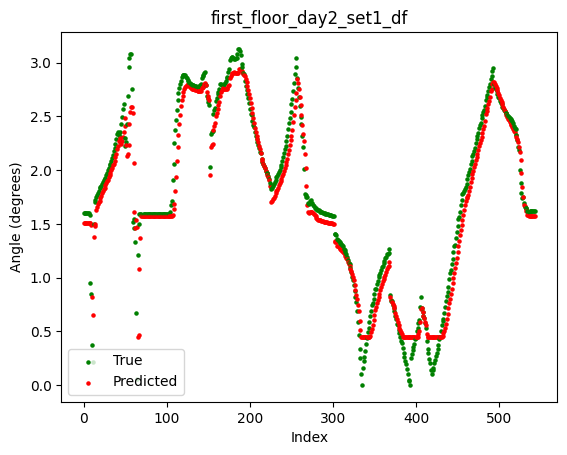

In [15]:
for idx in range(len(first_floor_day2_set1_df)):
    plt.scatter(idx, first_floor_day2_set1_df['angle'][idx], marker='o', color='g', s=5)
    plt.scatter(idx, first_floor_day2_set1_df['angle_pred'][idx], marker='o', color='r', s=5)
    # plt.scatter(idx, first_floor_day1_set1_df['pred_dist_corrected'][idx], marker='o', color='r', s=5)

plt.legend(['True', 'Predicted'])
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.title('first_floor_day2_set1_df')
plt.savefig('./_BEST MODELS/16-24-48-96-48-24-12-4-1/first_floor_day2_set1_df.png')

Text(0.5, 1.0, 'Corridor Set 2')

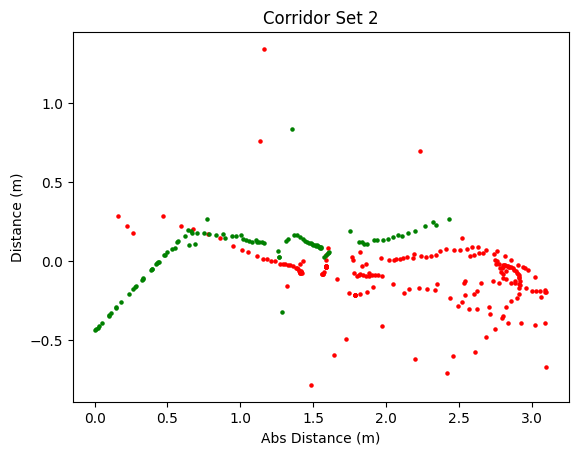

In [16]:
for idx in range(len(first_floor_day1_set2_df)-1):
    if first_floor_day1_set2_df['angle'][idx+1] < first_floor_day2_set2_df['angle'][idx]:
        plt.scatter(first_floor_day2_set2_df['angle'][idx], first_floor_day2_set2_df['angle_pred'][idx] - first_floor_day2_set2_df['angle'][idx], marker='o', color='r', s=5)
    elif first_floor_day2_set2_df['angle'][idx+1] > first_floor_day2_set2_df['angle'][idx]:
        plt.scatter(first_floor_day2_set2_df['angle'][idx], first_floor_day2_set2_df['angle'][idx] - first_floor_day2_set2_df['angle_pred'][idx], marker='o', color='g', s=5)


plt.xlabel('Abs Distance (m)')  
plt.ylabel('Distance (m)')
plt.title('Corridor Set 2')
# plt.savefig('./_BEST MODEL

In [17]:
def error_analysis_angle(df):
    # Initialize an empty list to store errors
    errors_coming = []
    errors_going = []
    df['angle_error'] = None

    df['angle_error'][0] = 0

    # Loop through the predicted values
    for i in range(len(df) - 1):
        # Compare the predicted value of the current point with the next point
        if df['angle'][i+1] < df['angle'][i]:
            # Calculate the error between the real values of the two points
            error = df['angle_pred'][i+1] - df['angle'][i+1]
            df['angle_error'][i+1] = error
            errors_coming.append(error)
        
        elif df['angle'][i+1] > df['angle'][i]:
            error = df['angle'][i+1] - df['angle_pred'][i+1]
            df['angle_error'][i+1] = error
            errors_going.append(error)

    # Calculate the average error
    average_error_coming = np.mean(errors_coming)
    average_error_going = np.mean(errors_going) 

    print("Errors between consecutive points where predicted value decreases:", errors_coming)
    print("Average error:", average_error_coming)

    print("Errors between consecutive points where predicted value increases:", errors_going)
    print("Average error:", average_error_going)

    print(len(errors_coming), len(errors_going))

    return average_error_coming, average_error_going


In [28]:
def error_analysis_dist(df):
    # Initialize an empty list to store errors
    errors_coming = []
    errors_going = []
    df['dist_error'] = None

    df['dist_error'][0] = 0 

    # Loop through the predicted values
    for i in range(len(df) - 1):
        # Compare the predicted value of the current point with the next point
        if df['abs_dist'][i+1] < df['abs_dist'][i]:
            # Calculate the error between the real values of the two points
            error = df['dist_pred'][i+1] - df['abs_dist'][i+1]
            df['dist_error'][i+1] = error
            errors_coming.append(error)
        
        elif df['abs_dist'][i+1] > df['abs_dist'][i]:
            error = df['abs_dist'][i+1] - df['dist_pred'][i+1]
            df['dist_error'][i+1] = error
            errors_going.append(error)

    # Calculate the average error
    average_error_coming = np.mean(errors_coming)
    average_error_going = np.mean(errors_going) 

    print("Errors between consecutive points where predicted value decreases:", errors_coming)
    print("Average error:", average_error_coming)

    print("Errors between consecutive points where predicted value increases:", errors_going)
    print("Average error:", average_error_going)

    print(len(errors_coming), len(errors_going))

    a = len(errors_coming)
    print(a)
    b = len(errors_going)

    return a, b, average_error_coming, average_error_going


In [29]:
len_P1_coming, len_P1_going, P1_coming_error, P1_going_error = error_analysis_angle(corridor_set1_df)
len_P2_coming, len_P2_going, P2_coming_error, P2_going_error = error_analysis_angle(corridor_set2_df)
len_Q1_coming, len_Q1_going, Q1_coming_error, Q1_going_error = error_analysis_angle(first_floor_day1_set1_df)
len_Q2_coming, len_Q2_going, Q2_coming_error, Q2_going_error = error_analysis_angle(first_floor_day1_set2_df)
len_R1_coming, len_R1_going, R1_coming_error, R1_going_error = error_analysis_angle(first_floor_day2_set1_df)
len_R2_coming, len_R2_going, R2_coming_error, R2_going_error = error_analysis_angle(first_floor_day2_set2_df)
len_S_coming, len_S_going, S_coming_error, S_going_error = error_analysis_angle(first_floor_straight)

Errors between consecutive points where predicted value decreases: [0.030383634459395292, 0.042559986254681714, 0.05393164455678101, 0.05855995974360839, 0.06018268323184994, 0.04962596596881674, 0.04167851459939387, 0.0315524443679045, -0.015112887778311324, -0.00464300457262401, -0.004118329616660921, 0.0006013228711305718, 0.001805069963076944, 0.0023684678471540543, 0.0011878053287361912, -0.005390056544623656, -0.00357790839576122, -0.004923248876173458, -0.004229335728365591, -0.006570845130848824, -0.008803013693118089, -0.014836965466029861, -0.031719606396761746, -0.013876592810514898, -0.01604227170101158, -0.01330158394515446, -0.012493288811893377, -0.012320914326563459, -0.01222328203588452, -0.011933997989790113, -0.011660463540528854, -0.014103922183829498, -0.014504158079189144, -0.012189329593399467, -0.016127844498015964, -0.020286229300401803, -0.024566129864259434, -0.02432604144745909, -0.024608033737195, -0.025345612287100527, -0.026629033749298925, -0.02598966931

C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_23188\585423013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angle_error'][0] = 0
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_23188\585423013.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angle_error'][i+1] = error
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_23188\585423013.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angle_error'][

ValueError: not enough values to unpack (expected 4, got 2)

In [46]:
first_floor_straight_error_coming_angle, first_floor_straight_error_going_angle

(0.026380704172013044, 0.0433162302127246)

In [47]:
first_floor_day1_set1_df

Unnamed: 0                 filename     gt_x      gt_y  gt_heading  \
0             0  1708418097.194988_F.jpg  1.08000  0.160000    0.034907   
1             1  1708418098.197396_F.jpg  1.08000  0.160000    0.034907   
2             2  1708418099.236570_F.jpg  1.08000  0.160000    0.034907   
3             3  1708418100.374095_F.jpg  1.15692  0.173431    0.032638   
4             4  1708418101.192885_F.jpg  1.29152  0.189010    0.035605   
..          ...                      ...      ...       ...         ...   
366         366  1708418579.225012_F.jpg  1.26218  0.307585    0.189194   
367         367  1708418580.351988_F.jpg  1.26218  0.307585    0.189194   
368         368  1708418581.178134_F.jpg  1.26218  0.307585    0.189194   
369         369  1708418582.173971_F.jpg  1.26218  0.307585    0.189194   
370         370  1708418583.200038_F.jpg  1.26218  0.307585    0.189194   

         x1      y1      x2      y2        X1  ...        Z4  abs_dist  \
0    1354.5  1583.6  1602.4  1927.2 -0.108961  ...  0.805395  1.091788   
1    1354.4  1583.5  1602.6  1927.1 -0.109083  ...  0.805419  1.091788   
2    1354.5  1583.8  1602.2  1926.9 -0.108958  ...  0.805631  1.091788   
3    1354.5  1583.6  1602.3  1926.9 -0.108961  ...  0.805611  1.169847   
4    1354.8  1583.4  1601.7  1927.5 -0.108599  ...  0.805343  1.305277   
..      ...     ...     ...     ...       ...  ...       ...       ...   
366  1309.0  1583.7  1545.9  1907.2 -0.163899  ...  0.827865  1.299118   
367  1309.5  1582.3  1545.9  1906.8 -0.163323  ...  0.828120  1.299118   
368  1309.4  1582.1  1544.9  1906.4 -0.163447  ...  0.828508  1.299118   
369  1309.3  1581.9  1544.6  1905.3 -0.163571  ...  0.829247  1.299118   
370  1309.3  1582.0  1544.7  1905.5 -0.163569  ...  0.829106  1.299118   

        angle         u         v         w         h  angle_pred  \
0    1.717875  0.513351  0.609514  0.086076  0.119306    1.599827   
1    1.717875  0.513368  0.609479  0.086181  0.119306    1.599820   
2    1.717875  0.513316  0.609497  0.086007  0.119132    1.599994   
3    1.719596  0.513333  0.609462  0.086042  0.119201    1.599912   
4    1.716112  0.513281  0.609531  0.085729  0.119479    1.599761   
..        ...       ...       ...       ...       ...         ...   
366  1.809831  0.495642  0.606059  0.082257  0.112326    1.652363   
367  1.809831  0.495729  0.605747  0.082083  0.112674    1.651757   
368  1.809831  0.495538  0.605642  0.081771  0.112604    1.652152   
369  1.809831  0.495469  0.605417  0.081701  0.112292    1.652443   
370  1.809831  0.495486  0.605469  0.081736  0.112326    1.652403   

     angle_error  pred_dist_corrected  
0              0             1.599827  
1           None             1.617377  
2           None             1.675985  
3       0.119684             1.617468  
4       -0.11635             1.617318  
..           ...                  ...  
366         None             1.728354  
367         None             1.669314  
368         None             1.728143  
369         None             1.728434  
370         None              1.66996  

[371 rows x 30 columns]

In [56]:
corridor_set1_df_error_coming_dist, corridor_set1_df_error_going_dist = error_analysis_dist(corridor_set1_df)
corridor_set2_df_error_coming_dist, corridor_set2_df_error_going_dist = error_analysis_dist(corridor_set2_df)
first_floor_day1_set1_df_error_coming_dist, first_floor_day1_set1_df_error_going_dist = error_analysis_dist(first_floor_day1_set1_df)
first_floor_day1_set2_df_error_coming_dist, first_floor_day1_set2_df_error_going_dist = error_analysis_dist(first_floor_day1_set2_df)
first_floor_day2_set1_df_error_coming_dist, first_floor_day2_set1_df_error_going_dist = error_analysis_dist(first_floor_day2_set1_df)
first_floor_day2_set2_df_error_coming_dist, first_floor_day2_set2_df_error_going_dist = error_analysis_dist(first_floor_day2_set2_df)
first_floor_straight_error_coming_dist, first_floor_straight_error_going_dist = error_analysis_dist(first_floor_straight)

C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_error'][0] = 0
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_error'][i+1] = error
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_error'][i+1

Errors between consecutive points where predicted value decreases: [0.7482683948916762, 0.6326928877400135, 0.37395229840323907, 0.6042063761509038, 0.9207775275768242, 0.871850065048994, 0.5246375842543536, 0.3285686499734055, 0.1471742331016923, 0.387834204256043, 0.6873485883496997, 0.11496889191922399, -0.19937497843023166, -0.20624627562192188, -0.17309501378386116, 0.20847295759562634, 0.22545028762350938, 0.2681188788355211, 0.32410980370904596, 0.3489428970809074, 0.41316016878993356, 0.5337103133653507, 0.523723299971147, 0.5599736039604988, 0.6244146971452649, 0.6634319522078256, 0.6157459733094433, 0.5044628755320879, 0.4977994271807731, 0.6422145410309641, 0.6235360702890445, 0.614596636737363, 0.5498027379732946, 0.5096190024613181, 0.5298894936824743, 0.544511496509994, 0.6405383751939211, 0.6837635768114358, 0.6345933511843787, 0.5273710804647194, 0.3904845244418804, 0.40377452335303987, 0.47975800782134215, 0.5714105087837824, 0.6040931668754514, 0.6338583936074267, 0.5

C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_error'][i+1] = error
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_error'][i+1] = error
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\1164545197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_erro

In [58]:
def mean_error(data1,data2,data3,num_data1,num_data2,num_data3):
    return (data1*num_data1 + data2*num_data2 + data3*num_data3)/(num_data1+num_data2+num_data3)

In [ ]:
corridor_set1_error_coming_angle = mean_error(first_floor_day1_set1_df_error_coming_angle, first_floor_day2_set1_df_error_coming_angle, first_floor_straight_error_coming_angle, len(first_floor_day1_set1_df), len(first_floor_day2_set1_df), len(corridor_set1_df))

In [51]:
def error_removal(df):
    df['pred_dist_corrected'] = None
    # Loop through the predicted values
    df['pred_dist_corrected'][0] = df['angle_pred'][0]   
    for i in range(len(df) - 1):
        # Compare the predicted value of the current point with the next point
        if df['angle_pred'][i+1] < df['angle_pred'][i]:
            # Calculate the error between the real values of the two points
            df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1] - mean_error_coming_set1_angle
        
        elif df['angle_pred'][i+1] > df['angle_pred'][i]:
            df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1] + mean_error_going_set1_angle
        
        else:
            df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1]

    mae = torch.mean(torch.abs(torch.tensor(df['pred_dist_corrected']) - torch.tensor(df['angle'])))*180/math.pi
    std_error = torch.std(torch.tensor(torch.abs(torch.tensor(df['pred_dist_corrected']) - torch.tensor(df['angle']))))*180/math.pi 

    # Print the results
    print("MAE:", mae)
    print("Standard Error:", std_error)


In [35]:
error_removal(corridor_set1_df)

MAE: tensor(3.7793, dtype=torch.float64)
Standard Error: tensor(5.9613, dtype=torch.float64)


C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][0] = df['angle_pred'][0]
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1] + mean_error_going_set1_angle
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [36]:
error_removal(first_floor_day1_set1_df)

MAE: tensor(4.3710, dtype=torch.float64)
Standard Error: tensor(4.7540, dtype=torch.float64)


C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][0] = df['angle_pred'][0]
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1] - mean_error_coming_set1_angle
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [37]:
error_removal(first_floor_day2_set1_df)

MAE: tensor(5.7526, dtype=torch.float64)
Standard Error: tensor(7.9235, dtype=torch.float64)


C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][0] = df['angle_pred'][0]
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_dist_corrected'][i+1] = df['angle_pred'][i+1] + mean_error_going_set1_angle
C:\Users\KalingaBandara\AppData\Local\Temp\ipykernel_2384\716368399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [94]:
first_floor_day1_set1_df

Unnamed: 0                 filename     gt_x      gt_y  gt_heading  \
0             0  1708418097.194988_F.jpg  1.08000  0.160000    0.034907   
1             1  1708418098.197396_F.jpg  1.08000  0.160000    0.034907   
2             2  1708418099.236570_F.jpg  1.08000  0.160000    0.034907   
3             3  1708418100.374095_F.jpg  1.15692  0.173431    0.032638   
4             4  1708418101.192885_F.jpg  1.29152  0.189010    0.035605   
..          ...                      ...      ...       ...         ...   
366         366  1708418579.225012_F.jpg  1.26218  0.307585    0.189194   
367         367  1708418580.351988_F.jpg  1.26218  0.307585    0.189194   
368         368  1708418581.178134_F.jpg  1.26218  0.307585    0.189194   
369         369  1708418582.173971_F.jpg  1.26218  0.307585    0.189194   
370         370  1708418583.200038_F.jpg  1.26218  0.307585    0.189194   

         x1      y1      x2      y2        X1  ...         u         v  \
0    1354.5  1583.6  1602.4  1927.2 -0.108961  ...  0.513351  0.609514   
1    1354.4  1583.5  1602.6  1927.1 -0.109083  ...  0.513368  0.609479   
2    1354.5  1583.8  1602.2  1926.9 -0.108958  ...  0.513316  0.609497   
3    1354.5  1583.6  1602.3  1926.9 -0.108961  ...  0.513333  0.609462   
4    1354.8  1583.4  1601.7  1927.5 -0.108599  ...  0.513281  0.609531   
..      ...     ...     ...     ...       ...  ...       ...       ...   
366  1309.0  1583.7  1545.9  1907.2 -0.163899  ...  0.495642  0.606059   
367  1309.5  1582.3  1545.9  1906.8 -0.163323  ...  0.495729  0.605747   
368  1309.4  1582.1  1544.9  1906.4 -0.163447  ...  0.495538  0.605642   
369  1309.3  1581.9  1544.6  1905.3 -0.163571  ...  0.495469  0.605417   
370  1309.3  1582.0  1544.7  1905.5 -0.163569  ...  0.495486  0.605469   

            w         h  angle_pred  dist_pred  angle_error  coming  going  \
0    0.086076  0.119306    1.599827   0.964821            0       0      0   
1    0.086181  0.119306    1.599820   0.964821            0       0      0   
2    0.086007  0.119132    1.599994   0.964821            0       0      0   
3    0.086042  0.119201    1.599912   0.964821     0.119684       0      1   
4    0.085729  0.119479    1.599761   0.964821     -0.11635       1      0   
..        ...       ...         ...        ...          ...     ...    ...   
366  0.082257  0.112326    1.652363   0.973641            0       0      0   
367  0.082083  0.112674    1.651757   0.970101            0       0      0   
368  0.081771  0.112604    1.652152   0.973767            0       0      0   
369  0.081701  0.112292    1.652443   0.977752            0       0      0   
370  0.081736  0.112326    1.652403   0.977103            0       0      0   

     pred_dist_corrected  
0               1.599827  
1               1.536627  
2               1.691029  
3               1.536719  
4               1.536568  
..                   ...  
366             1.743399  
367             1.588564  
368             1.743188  
369             1.743478  
370              1.58921  

[371 rows x 33 columns]